In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 29.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Preparing data

Using data from Hugging face

Working reference by
[Paper](https://arxiv.org/pdf/2110.15718v3.pdf)



In [3]:
from datasets import load_dataset

dataset = load_dataset("sms_spam")

Generating train split:   0%|          | 0/5574 [00:00<?, ? examples/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sms', 'label'],
        num_rows: 5574
    })
})

In [5]:
data_train_sms=dataset['train']
sms_texts=[]
label=[]
for text,labels in zip(data_train_sms['sms'],data_train_sms['label']):
  sms_texts.append(text)
  label.append(labels)

In [6]:
df_sms_spam=pd.DataFrame({
    "sms text":sms_texts,
    "labels":label
})

# EDA

In [7]:
df_sms_spam

,sms text,labels
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...
5569,This is the 2nd time we have tried 2 contact u...,1
5570,Will ü b going to esplanade fr home?\n,0
5571,"Pity, * was in mood for that. So...any other s...",0
5572,The guy did some bitching but I acted like i'd...,0


Check how many labels

In [8]:
df_sms_spam['labels'].value_counts()

0    4827
1     747
Name: labels, dtype: int64

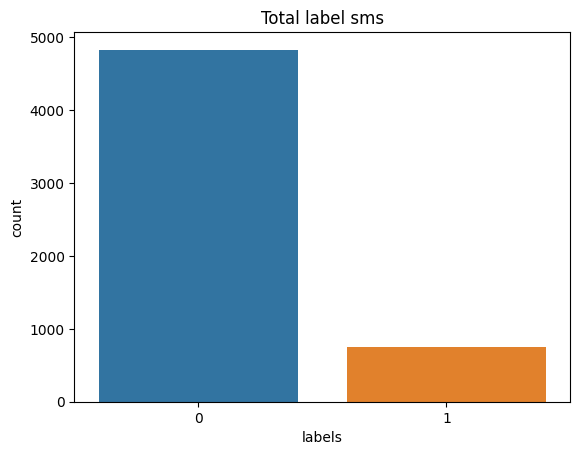

In [9]:
sns.countplot(x=df_sms_spam['labels'])
plt.title("Total label sms")
plt.show()

# Text preprocessing

## First of all, text messages were
prepared by splitting each message into a list of words

## text preprocessing techniques like stemming and stop words removal.

In [10]:
from nltk.stem import *
stemmer = PorterStemmer()

In [11]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('stopwords')
stp=stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
def stemsWords(text):
  text=stemmer.stem(text)
  return text

def flatten(l):
    """
    Same as
    flat_list = []
    for sublist in l:
    for item in sublist:
        flat_list.append(item)

    Example =[[1,2,3,4,5]] - > [1,2,3,4,5]
    """
    return " ".join([item for sublist in l for item in sublist])

def remove_stop_words(text):
  clean_words = []
  text=text.split()
  perulangan_text=[word for word in text if word not in stp]
  clean_words.append(perulangan_text)
  return flatten(clean_words)

In [13]:
def preprocessing_text(text):
  text=remove_stop_words(text)
  text=stemsWords(text)
  return text

In [14]:
%%time
df_sms_spam['Clean_text']=df_sms_spam['sms text'].apply(preprocessing_text)

CPU times: user 184 ms, sys: 2.21 ms, total: 187 ms
Wall time: 187 ms


In [15]:
train_sentences=df_sms_spam['Clean_text'].to_list()

# Afterward, each word was
transformed into a sequence of numbers called a word vector; the word vector is generated using a word embedding
technique as explained in "Word embedding"

In [16]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [17]:
import random
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
yar say got error.

Sentence after embedding:
[-0.01140213 -0.01831092  0.00829669 -0.01919336  0.08133593 -0.02735036
 -0.05342252 -0.03947569  0.00943821  0.03940858  0.04227641 -0.02015187
 -0.08397266 -0.08236803 -0.01276495 -0.0279448   0.05613042 -0.02464522
  0.03678168 -0.02424833 -0.02227608  0.03224855 -0.00140911  0.04403498
 -0.04221113  0.07093397  0.06423816  0.0242459  -0.03955304 -0.01028522] (truncated output)...

Length of sentence embedding:
512


In [18]:
X_embed=tf_hub_embedding_layer(train_sentences)

In [19]:
X_embed

<tf.Tensor: shape=(5574, 512), dtype=float32, numpy=
array([[ 0.02112633, -0.0386215 , -0.00032354, ..., -0.04223671,
         0.00219074, -0.09668012],
       [-0.01459222,  0.07797027, -0.03176386, ..., -0.02766832,
         0.01186169,  0.04429685],
       [-0.06489021, -0.08707049,  0.02931668, ..., -0.0678794 ,
        -0.05303235, -0.0355957 ],
       ...,
       [ 0.01949391,  0.03333146,  0.077934  , ...,  0.02246847,
        -0.01618201,  0.05756629],
       [-0.01566824, -0.08123073,  0.03313924, ..., -0.00734642,
        -0.02299803,  0.05534538],
       [ 0.06508131,  0.03481466,  0.0659538 , ..., -0.04339778,
         0.03233333, -0.04087827]], dtype=float32)>

In [20]:
y=df_sms_spam['labels']

#  handling imbalance labels

SMOTE over-sampling
technique was applied for balancing data before feeding it
into the classifier

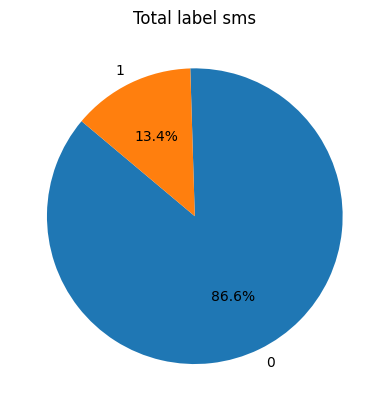

In [21]:
plt.pie(x=df_sms_spam['labels'].value_counts(),labels=df_sms_spam['labels'].unique(),autopct='%1.1f%%',startangle=140)
plt.title("Total label sms")
plt.show()

the labels has imbalance data
* 1 (spam) 13.4% of the total data
* 0 (ham) 86.6% of the total data

In [22]:
from imblearn.over_sampling import SMOTE

# modelling

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline
from sklearn.metrics import *
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

Split train test <br>
Therefore, balancing
the class distribution is necessary to obtain accurate results.
Initially, the dataset was split into two subsets: 80% of the
messages are for training and the remaining 20% are for testing and validation

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
len(X_embed),len(y)

(5574, 5574)

In [26]:
X_embed=[value for value in X_embed]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_embed, y, test_size=0.2, random_state=42)

In [28]:
print(f'Length train data : {len(X_train)}')
print(f'Length test data : {len(X_test)}')

Length train data : 4459
Length test data : 1115


## Naives bayes

In [29]:
model_NB=Pipeline([
    ('over sampling',SMOTE(random_state=0)), #  handling imbalance labels SMOTE over-sampling
    ('nb',GaussianNB())
])

In [30]:
%%time
model_NB.fit(X_train,y_train)

CPU times: user 589 ms, sys: 59.5 ms, total: 648 ms
Wall time: 778 ms


Pipeline(steps=[('over sampling', SMOTE(random_state=0)), ('nb', GaussianNB())])

In [31]:
model_predict_nb=model_NB.predict(X_test)

In [52]:
model_predict_nb_proba=model_NB.predict_proba(X_test)

In [53]:
model_predict_nb_proba

array([[1.00000000e+00, 7.44983541e-67],
       [9.99999997e-01, 2.52843704e-09],
       [1.00000000e+00, 6.01118868e-60],
       ...,
       [1.00000000e+00, 4.16336068e-10],
       [1.00000000e+00, 2.62287466e-50],
       [3.07059474e-38, 1.00000000e+00]])

## KNN

In [32]:
model_knn=Pipeline([
    ('over sampling',SMOTE(random_state=0)), #  handling imbalance labels SMOTE over-sampling
    ('knn',KNeighborsClassifier(metric='cosine'))
])

In [33]:
model_knn.fit(X_train,y_train)

Pipeline(steps=[('over sampling', SMOTE(random_state=0)),
                ('knn', KNeighborsClassifier(metric='cosine'))])

In [34]:
model_predict=model_knn.predict(X_test)

In [35]:
model_predict

array([0, 1, 0, ..., 0, 0, 1])

## SVM

In [37]:
model_svm=Pipeline([
    ('over sampling',SMOTE(random_state=0)), #  handling imbalance labels SMOTE over-sampling
    ('SVM',SVC())
])

In [38]:
model_svm.fit(X_train,y_train)

Pipeline(steps=[('over sampling', SMOTE(random_state=0)), ('SVM', SVC())])

In [39]:
model_predict_svm=model_svm.predict(X_test)

# Evalutaion

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [40]:
from helper_functions import *

## Naives bayes

In [41]:
result_NB=calculate_results(y_test,model_predict_nb)

In [42]:
result_NB

{'accuracy': 96.95067264573991,
 'precision': 0.9689684378882921,
 'recall': 0.9695067264573991,
 'f1': 0.9690118255460726}

In [64]:
print(f"Wrong prediction: {(y_test!=model_predict_nb).sum()}")
print(f"Correct prediction: {(y_test==model_predict_nb).sum()}")
print(classification_report(y_test,model_predict_nb))

Wrong prediction: 34
Correct prediction: 1081
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       954
           1       0.93      0.86      0.89       161

    accuracy                           0.97      1115
   macro avg       0.95      0.92      0.94      1115
weighted avg       0.97      0.97      0.97      1115



**Observation**
* We can see evaluate metrics
* accuracy 96.95 %
* recall 0.96
* f1 score 0.96
* Wrong prediction 34 total
* correct prediciction 1081


## SVM

In [44]:
result_svm=calculate_results(y_test,model_predict_svm)

In [45]:
result_svm

{'accuracy': 98.38565022421525,
 'precision': 0.9837491726937364,
 'recall': 0.9838565022421525,
 'f1': 0.983639876538636}

In [67]:
print(f'Wrong prediciotn :{(y_test!=model_predict_svm).sum()}')
print(f'Correct prediction :{(y_test==model_predict_svm).sum()}')
print(classification_report(y_test,model_predict_svm))

Wrong prediciotn :18
Correct prediction :1097
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       954
           1       0.97      0.91      0.94       161

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115



**Observation Model SVM**
* We can see evaluate metrics
* accuracy 98%
* recall 0.96
* f1 score 0.96
* Wrong prediction 18 total
* correct prediciction 1097






## KNN

In [47]:
result_knn=calculate_results(y_test,model_predict)

In [48]:
result_knn

{'accuracy': 95.24663677130046,
 'precision': 0.9624597483145351,
 'recall': 0.9524663677130045,
 'f1': 0.9548933407325028}

In [68]:
print(f'Wrong prediciotn :{(y_test!=model_predict).sum()}')
print(f'Correct prediction :{(y_test==model_predict).sum()}')
print(classification_report(y_test,model_predict))

Wrong prediciotn :53
Correct prediction :1062
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       954
           1       0.76      0.98      0.86       161

    accuracy                           0.95      1115
   macro avg       0.88      0.96      0.91      1115
weighted avg       0.96      0.95      0.95      1115



**Observation Model K nearest neighbor**
* We can see evaluate metrics
* accuracy 95%
* recall 0.96
* f1 score 0.96
* Wrong prediction 53 total
* correct prediciction 1062






# Check overfitt or underfitt

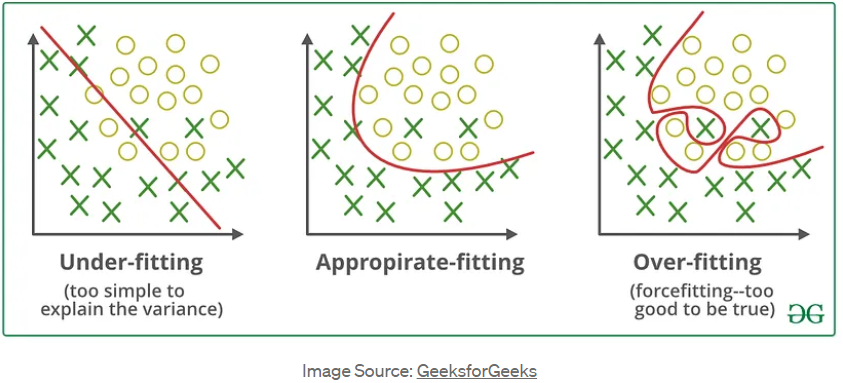

## Naives bayes

In [ ]:
values = [1,14,15]
train_scores=[]
test_scores=[]
for i in values:
  model_svm=Pipeline([
    ('over sampling',SMOTE(random_state=0)), #  handling imbalance labels SMOTE over-sampling
    ('SVM',SVC(degree=i))
])
  # configure the model
  # fit model on the training dataset
  model_svm.fit(X_train, y_train)
  # evaluate on the train dataset
  train_yhat = model_svm.predict(X_train)
  train_acc = accuracy_score(y_train, train_yhat)
  train_scores.append(train_acc)
  # evaluate on the test dataset
  test_yhat = model_svm.predict(X_test)
  test_acc = accuracy_score(y_test, test_yhat)
  test_scores.append(test_acc)
  # summarize progress
  print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores vs number of neighbors
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.title("Check Overfitt or underfit in SVM")
plt.legend()
plt.show()

## SVM

>1, train: 1.000, test: 0.984
>14, train: 1.000, test: 0.984
>15, train: 1.000, test: 0.984


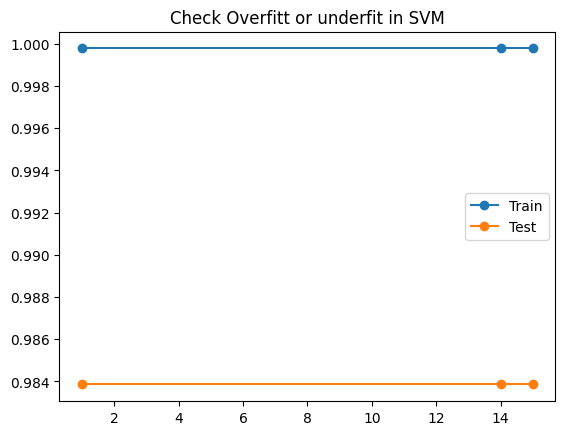

In [50]:
values = [1,14,15]
train_scores=[]
test_scores=[]
for i in values:
  model_svm=Pipeline([
    ('over sampling',SMOTE(random_state=0)), #  handling imbalance labels SMOTE over-sampling
    ('SVM',SVC(degree=i))
])
  # configure the model
  # fit model on the training dataset
  model_svm.fit(X_train, y_train)
  # evaluate on the train dataset
  train_yhat = model_svm.predict(X_train)
  train_acc = accuracy_score(y_train, train_yhat)
  train_scores.append(train_acc)
  # evaluate on the test dataset
  test_yhat = model_svm.predict(X_test)
  test_acc = accuracy_score(y_test, test_yhat)
  test_scores.append(test_acc)
  # summarize progress
  print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores vs number of neighbors
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.title("Check Overfitt or underfit in SVM")
plt.legend()
plt.show()

Underfitt model in svm
* train data (underfit)
* test data (underfit)

## KNN

>1, train: 1.000, test: 0.978
>2, train: 1.000, test: 0.979
>3, train: 0.985, test: 0.963
>4, train: 0.988, test: 0.971
>5, train: 0.971, test: 0.952
>6, train: 0.973, test: 0.957
>7, train: 0.959, test: 0.943
>8, train: 0.963, test: 0.946
>9, train: 0.953, test: 0.939
>10, train: 0.957, test: 0.940
>11, train: 0.946, test: 0.936
>12, train: 0.950, test: 0.939
>13, train: 0.942, test: 0.931
>14, train: 0.944, test: 0.933
>15, train: 0.939, test: 0.926
>16, train: 0.944, test: 0.933
>17, train: 0.936, test: 0.923
>18, train: 0.940, test: 0.928
>19, train: 0.935, test: 0.923
>20, train: 0.938, test: 0.930
>21, train: 0.933, test: 0.921
>22, train: 0.937, test: 0.926
>23, train: 0.931, test: 0.920
>24, train: 0.935, test: 0.926
>25, train: 0.928, test: 0.920
>26, train: 0.931, test: 0.924
>27, train: 0.928, test: 0.912
>28, train: 0.930, test: 0.917
>29, train: 0.926, test: 0.909
>30, train: 0.927, test: 0.911
>31, train: 0.924, test: 0.906
>32, train: 0.927, test: 0.909
>33, train: 0.924

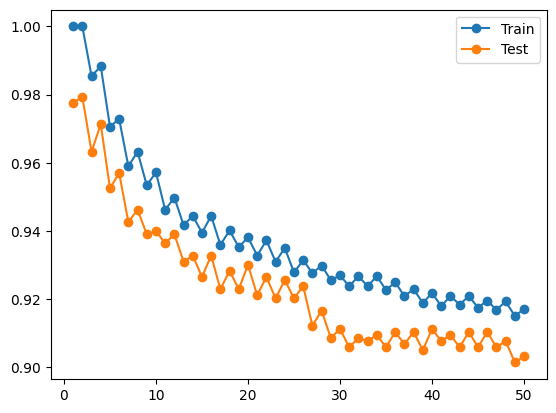

In [51]:

values = [i for i in range(1, 51)]

train_scores=[]
test_scores=[]
for k in values:
  model_knn=Pipeline([
    ('over sampling',SMOTE(random_state=0)), #  handling imbalance labels SMOTE over-sampling
    ('knn',KNeighborsClassifier(n_neighbors=k,metric='cosine'))
])
  # configure the model
  # fit model on the training dataset
  model_knn.fit(X_train, y_train)
  # evaluate on the train dataset
  train_yhat = model_knn.predict(X_train)
  train_acc = accuracy_score(y_train, train_yhat)
  train_scores.append(train_acc)
  # evaluate on the test dataset
  test_yhat = model_knn.predict(X_test)
  test_acc = accuracy_score(y_test, test_yhat)
  test_scores.append(test_acc)
  # summarize progress
  print('>%d, train: %.3f, test: %.3f' % (k, train_acc, test_acc))
# plot of train and test scores vs number of neighbors
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()

The models good not underfitt or overfitt

# Summary

In [75]:
summary_df=pd.DataFrame([result_NB,result_knn,result_svm],index=['Naives bayes',"K- nearest neighbor","SVM"])

In [76]:
summary_df

,accuracy,precision,recall,f1
Naives bayes,96.950673,0.968968,0.969507,0.969012
K- nearest neighbor,95.246637,0.962460,0.952466,0.954893
SVM,98.385650,0.983749,0.983857,0.983640


In [77]:
# Summary prediction
Wrong_prediction_naivesBayes=(y_test!=model_predict_nb).sum()
Correct_prediction_naivesBayes=(y_test==model_predict_nb).sum()

Correct_prediction_knn=(y_test==model_predict).sum()
Wrong_prediction_knn=(y_test!=model_predict).sum()

Correct_prediction_svm=(y_test==model_predict_svm).sum()
Wrong_prediction_svm=(y_test!=model_predict_svm).sum()

In [85]:
summary_prediction_NB=pd.DataFrame([[Wrong_prediction_naivesBayes,Correct_prediction_naivesBayes]],index=["Naives bayes"],columns=["Wrong prediction","Correct prediction"])
summary_prediction_knn=pd.DataFrame([[Wrong_prediction_knn,Correct_prediction_knn]],index=["KNN"],columns=["Wrong prediction","Correct prediction"])
summary_prediction_SVM=pd.DataFrame([[Wrong_prediction_svm,Correct_prediction_svm]],index=["SVM"],columns=["Wrong prediction","Correct prediction"])

In [92]:
summary_all_prediction_model=pd.concat([summary_prediction_NB,summary_prediction_knn,summary_prediction_SVM]).reset_index().rename(columns={'index':"Model"})

In [93]:
summary_all_prediction_model

,Model,Wrong prediction,Correct prediction
0,Naives bayes,34,1081
1,KNN,53,1062
2,SVM,18,1097


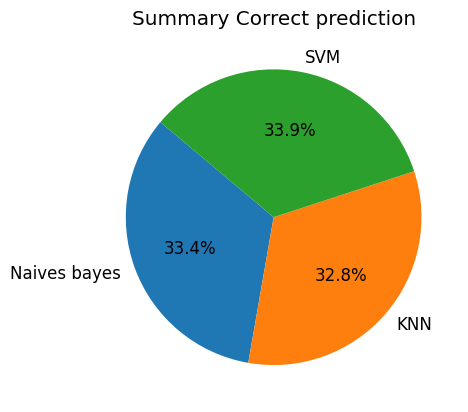

In [101]:
plt.pie(summary_all_prediction_model['Correct prediction'],labels=summary_all_prediction_model.Model.unique(),autopct='%1.1f%%',startangle=140);
plt.title('Summary Correct prediction')
plt.show()

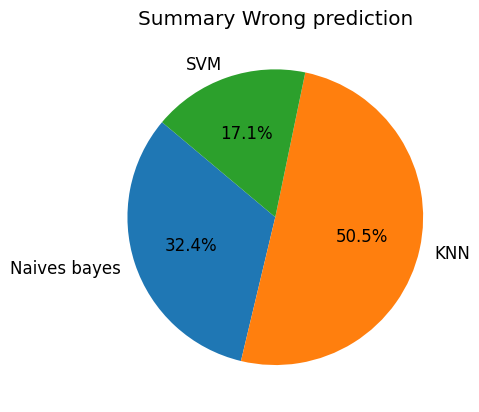

In [104]:
plt.pie(summary_all_prediction_model['Wrong prediction'],labels=summary_all_prediction_model.Model.unique(),autopct='%1.1f%%',startangle=140);
plt.title('Summary Wrong prediction')
plt.show()

**OBSERVATION** <br>
Pie chart Correct prediction <br>
*   SVM 33.9 %
*   Naives bayes 33.4 %
*   KNN 32.8 %

Pie chart Wrong prediction <br>
*   SVM 17.1 %
*   Naives bayes 32.4 %
*   KNN 50.5 %

**Summary** <br>
* KNN has most wrong prediction instead SVM and Naives bayes
* SVM has most correct prediction instead KNN and Naives bayes
